In [1]:
'''Main'''
import numpy as np
import pandas as pd
import os, time, re
import pickle, gzip, datetime

'''Data Viz'''
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import Grid
from IPython.display import SVG
%matplotlib inline

'''Data Prep and Model Evaluation'''
from sklearn import preprocessing as pp
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss, accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, mean_squared_error

'''Algos'''
import lightgbm as lgb

'''TensorFlow and Keras'''
import tensorflow as tf
from tensorflow import keras
K = keras.backend

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import BatchNormalization, Input, Lambda
from tensorflow.keras.layers import Embedding, Flatten, dot
from tensorflow.keras.layers import Conv2D, MaxPool2D, LeakyReLU, Reshape
from tensorflow.keras.layers import UpSampling2D, Conv2DTranspose
from tensorflow.keras import regularizers
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop

In [2]:
# To make the output stable across runs
tf.random.set_seed(42)
np.random.seed(42)

In [3]:
# Load the datasets
#Store image data into a 4d tensor as required by Keras. Also create one-hot vectors form the labels
current_path = os.getcwd()
file = os.path.sep.join(['', 'datasets', 'mnist_data', 'mnist.pkl.gz'])
f = gzip.open(current_path+file, 'rb')
train_set, validation_set, test_set = pickle.load(f, encoding='latin1')
f.close()

X_train, y_train = train_set[0], train_set[1]
X_validation, y_validation = validation_set[0], validation_set[1]
X_test, y_test = test_set[0], test_set[1]

In [4]:
# Reshape for TensorFlow
X_train_keras = X_train.reshape(50000,28,28,1)
X_validation_keras = X_validation.reshape(10000,28,28,1)
X_test_keras = X_test.reshape(10000,28,28,1)

y_train_keras = to_categorical(y_train)
y_validation_keras = to_categorical(y_validation)
y_test_keras = to_categorical(y_test)

In [5]:
# Create Pandas DataFrames from the datasets
train_index = range(0,len(X_train))
validation_index = range(len(X_train),len(X_train)+len(X_validation))
test_index = range(len(X_train)+len(X_validation),len(X_train)+ \
                   len(X_validation)+len(X_test))

X_train = pd.DataFrame(data=X_train,index=train_index)
y_train = pd.Series(data=y_train,index=train_index)

X_validation = pd.DataFrame(data=X_validation,index=validation_index)
y_validation = pd.Series(data=y_validation,index=validation_index)

X_test = pd.DataFrame(data=X_test,index=test_index)
y_test = pd.Series(data=y_test,index=test_index)

In [6]:
# Define function to view digit
def view_digit(X, y, example):
    label = y.loc[example]
    image = X.loc[example,:].values.reshape([28,28])
    plt.title('Example: %d  Label: %d' % (example, label))
    plt.imshow(image, cmap=plt.get_cmap('gray'))
    plt.show()

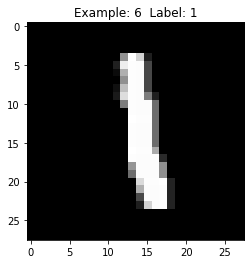

In [7]:
# View the first digit
view_digit(X_train, y_train, 6)

In [9]:
#Convolutional Neutal Network CNN Model

# Define model graph
model = Sequential() # Begin Model Creation

#Initial Two layres
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation ='relu', input_shape = (28,28,1))) #Relu activation function
model.add(Conv2D(filters = 32, kernel_size = (5,5), padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25)) #Regularization to reduce overfitting

#Second set of convolutional layers
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(256, activation = "relu")) #Regular neural network with 256 hidden units
model.add(Dropout(0.5)) #50% dropout
model.add(Dense(10, activation = "softmax")) #10 class classification

In [10]:
# Train CNN
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

cnn_history = model.fit(X_train_keras, y_train_keras, validation_data=(X_validation_keras, y_validation_keras), epochs=100)

Epoch 1/100
1563/1563 [==============================] - 186s 118ms/step - loss: 0.1884 - accuracy: 0.9407 - val_loss: 0.0467 - val_accuracy: 0.9867
Epoch 2/100
1563/1563 [==============================] - 186s 119ms/step - loss: 0.0671 - accuracy: 0.9800 - val_loss: 0.0400 - val_accuracy: 0.9894
Epoch 3/100
1563/1563 [==============================] - 182s 116ms/step - loss: 0.0551 - accuracy: 0.9829 - val_loss: 0.0355 - val_accuracy: 0.9904
Epoch 4/100
1563/1563 [==============================] - 180s 115ms/step - loss: 0.0437 - accuracy: 0.9871 - val_loss: 0.0353 - val_accuracy: 0.9916
Epoch 5/100
1563/1563 [==============================] - 181s 116ms/step - loss: 0.0378 - accuracy: 0.9883 - val_loss: 0.0310 - val_accuracy: 0.9918
Epoch 6/100
1563/1563 [==============================] - 182s 117ms/step - loss: 0.0359 - accuracy: 0.9894 - val_loss: 0.0296 - val_accuracy: 0.9917
Epoch 7/100
1563/1563 [==============================] - 181s 116ms/step - loss: 0.0300 - accuracy: 0.9907

In [11]:
# View keys
print(cnn_history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


CNN Final Accuracy 0.995419979095459


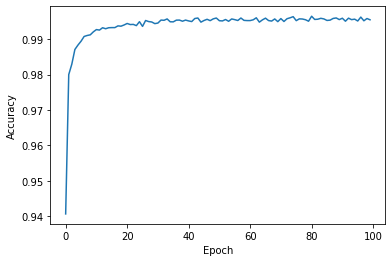

In [12]:
# Plot Accuracy of CNN
print("CNN Final Accuracy", cnn_history.history['accuracy'][-1])
pd.Series(cnn_history.history['accuracy']).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

CNN Final Loss 0.01992218568921089


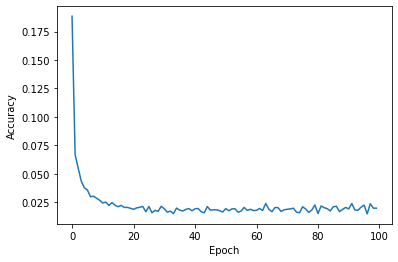

In [16]:
# Plot Accuracy of CNN
print("CNN Final Loss", cnn_history.history['loss'][-1])
pd.Series(cnn_history.history['loss']).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

CNN Final val_Loss 0.05576028302311897


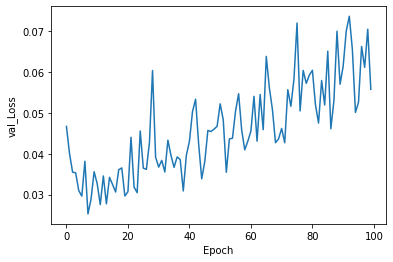

In [23]:
print("CNN Final val_Loss", cnn_history.history['val_loss'][-1])
pd.Series(cnn_history.history['val_loss']).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("val_Loss")
plt.show()

CNN Final val_Accuracy 0.9940999746322632


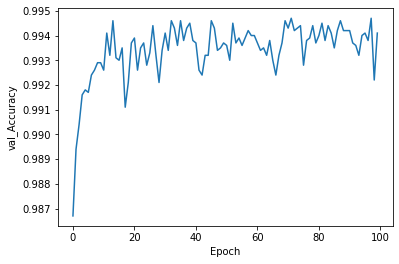

In [22]:
print("CNN Final val_Accuracy", cnn_history.history['val_accuracy'][-1])
pd.Series(cnn_history.history['val_accuracy']).plot(logy=False)
plt.xlabel("Epoch")
plt.ylabel("val_Accuracy")
plt.show()

In [24]:
#Deep Convolutional Generative Adversarial Network (DCGAN)
# Define function to develop model
class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time))

class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model
        
    def generator(self, depth=256, dim=7, dropout=0.3, momentum=0.8, window=5, input_dim=100, output_depth=1): 
    #dropout 30% defult, depth of the tensor 256 defult, dim= other dimenstions defult 7, bacth normalization defult momentum of .8, initial input dimensions are 100 and final output is 28x28
    # dropout and batch normailization are regularizers to help the neural network avoid overfitting 
    #call sequentioal to build generator. Input dimensions of 100 and output dimenstions of 7x7x256
    #Use batch normalization, RelU activation, and perform dropout
        if self.G:
            return self.G
        self.G = Sequential()
        self.G.add(Dense(dim*dim*depth, input_dim=input_dim))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim, dim, depth)))
        self.G.add(Dropout(dropout))
    #Perform Upsampling and transposed convolution three times each with a depth of the output space from 256, 128, 64
    #Maintian convolution window of 5x5 and stride of 1 (defult) each convolution step we preform batch normalization and use the ReLU activation function
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), window, padding='same'))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))

        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), window, padding='same'))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(int(depth/8), window, padding='same'))
        self.G.add(BatchNormalization(momentum=momentum))
        self.G.add(Activation('relu'))
    # last the generator will output a 28x28 image with the same dimensions as the original image
        self.G.add(Conv2DTranspose(output_depth, window, padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()
        return self.G

    def discriminator(self, depth=64, dropout=0.3, alpha=0.3):
    #Discriminator set dropout to .3, depth as 64, alpha for the LeakyReLU function as .3 - LeakyReLU is advanced activation function allowing a small gradient when the unit is not active. Preferred for image problems 
    #First load the 28x28x1 image and perform convotion with 64 channels- 5x5 filter and a stride of 2. LeakyReLU as the activation function and perform dropout.
    #Perform this process x3, doubleing the depth each time while decreasing other dimensions
        if self.D:
            return self.D
        self.D = Sequential()
        input_shape = (self.img_rows, self.img_cols, self.channel)
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,
            padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=alpha))
        self.D.add(Dropout(dropout))
    #Flatten the image and use sigmoid function to output a probability that designates the discriminators confidence in calling the input real or not (0=fake 1=real)
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D

    def discriminator_model(self):
    #Fake detection.
    #RMSprop optimizer function. Binary cross-entropy loss function, report metric is accuracy 
        if self.DM:
            return self.DM
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', \
                        optimizer=optimizer, metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', \
                        optimizer=optimizer, metrics=['accuracy'])
        return self.AM
        

        #First initilize the class for the 28x28x1 images and use the generator, discriminator, and madversarial model
class MNIST_DCGAN(object):
    def __init__(self, x_train):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1

        self.x_train = x_train

        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()

    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        #Will train for 2k epochs and use a batch size of 256. Will feed batches of images into DCGAN. Generator will generate images, the discriminator will call out images as real or fake.
        #As the generator and discriminator fight, the synthetic images become more and more similar to the original images
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        for i in range(train_steps):
            images_train = self.x_train[np.random.randint(0,
                self.x_train.shape[0], size=batch_size), :, :, :]
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = self.generator.predict(noise)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            
            d_loss = self.discriminator.train_on_batch(x, y)

            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], \
                                                      a_loss[1])
            print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, \
                        samples=noise_input.shape[0],\
                        noise=noise_input, step=(i+1))
    
    #Plot synthetic images
    def plot_images(self, save2file=False, fake=True, samples=16, \
                    noise=None, step=0):
        current_path = os.getcwd()
        file = os.path.sep.join(['', 'images', 'chapter12', 'synthetic_mnist', ''])
        filename = 'mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(current_path+file+filename)
            plt.close('all')
        else:
            plt.show()

In [25]:
# Initialize MNIST DCGAN and train
mnist_dcgan = MNIST_DCGAN(X_train_keras)
timer = ElapsedTimer()
mnist_dcgan.train(train_steps=10000, batch_size=256, save_interval=500)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_7 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_10 (Conv2D)          (None, 4, 4, 256)        

c:\Users\JMcKay\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


Non-trainable params: 0
_________________________________________________________________
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 12544)             1266944   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 activation_1 (Activation)   (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 dropout_10 (Dropout)        (None, 7, 7, 256)         0         
                                                                 
 up_sampling2d (UpSampling2D  

KeyboardInterrupt: 

Elapsed: 5.143083256085713 hr 


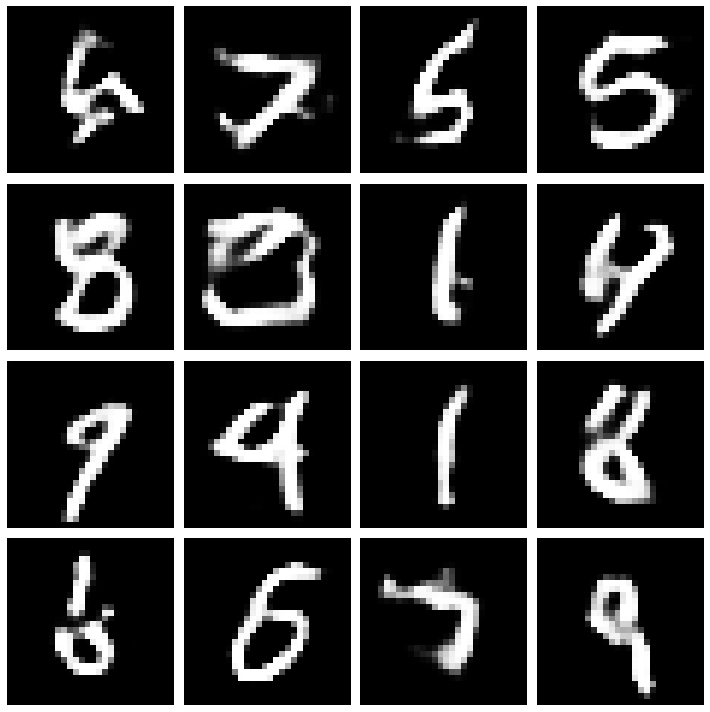

In [30]:
# Generate batch of synthetic MNIST images
timer.elapsed_time()
mnist_dcgan.plot_images(fake=True)
mnist_dcgan.plot_images(fake=False, save2file=True)